<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/rp_os_pyramids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Class

As of now this class is the "final product", a grouping of the experiments below

In [ ]:
import pandas as pd
import numpy as np
from math import floor, ceil
from datetime import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(style='whitegrid')
import sys

class Pyramid:
  def __init__(self,document):
    self.document = document
    self.climber = document.split('/')[-2].replace('-',' ').title()
    self.grade_chart = pd.read_html("https://www.mountainproject.com/international-climbing-grades")
    self.old_ropes = self.grade_chart[0].YDSUSA[:-1].to_list()
    self.new_ropes = [0,0,0,0,1,2,3,4,5,6,7,7.4,8,8.4,8.8,9,9.4,9.8]+list(np.round(np.arange(10,16,.1),1))
    self.ropes_convert = dict(zip(self.old_ropes, self.new_ropes))
   
    self.data = self._clean_data(self.document)
    # Split Trad and Sport data
    self.trad = self.data[(self.data['type'] == 'Trad') | (self.data['type'] == 'Trad, Sport') | (self.data['type'] == 'Trad, Alpine') | (self.data['type'] == 'Trad, Aid')]
    self.sport = self.data[(self.data['type'] == 'Sport') | (self.data['type'] == 'Sport, TR')]
    self.trad_rp = self.trad[self.trad.lead_style.isin(['Redpoint','Pinkpoint'])]
    self.trad_os = self.trad[self.trad.lead_style == 'Onsight']
    self.trad_os.grade.apply(self._x_round).value_counts().sort_index(ascending=False)
    self.sport_rp = self.sport[self.sport.lead_style.isin(['Redpoint','Pinkpoint'])]
    self.sport_os = self.sport[self.sport.lead_style == 'Onsight']

    self.sport_combined = pd.concat([self.sport_rp,self.sport_os], axis=0)
    self.trad_combined = pd.concat([self.trad_rp, self.trad_os], axis=0)
    self.styles = [self.sport_combined, self.trad_combined]
    date = dt.now().strftime('%-d%b%Y')
    self.pyramids = []
    self.titles = []
    for i, style in enumerate(self.styles):
      if not style.empty:
        self.title = f"{self.climber}\n{style.iloc[0]['type'].split(',')[0]} pyramid \n as of {date}\n"
        self.top_pyramid = style.grade.apply(self._x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
        self.top_pyramid.columns = ('grade','count')
        self.top_pyramid.grade = self.top_pyramid.grade.apply(self._grade_to_letter)
        self.pyramids.append(self.top_pyramid)
        self.titles.append(self.title)
    
    self.sport_pyramid = self.pyramids[0]
    self.trad_pyramid = self.pyramids[1]

    self.grades_list = '0 1 2 3 4 5 6 7 7+ 8- 8 8+ 9- 9 9+'.split()
    self.numbs = '10 11 12 13 14 15'.split()
    self.letters =  list('abcd')
    for i in self.numbs:
      for j in self.letters:
        self.grades_list.append(i+j)

  def _sum_miles(self, length_data):
    min_date = length_data.Date.min().year
    max_date = length_data.Date.max().year + 1
    front_dates = list(range(min_date,max_date))
    back_dates = [d + 1 for d in front_dates]
    front_dates = [f'01/01/{y}' for y in front_dates]
    back_dates = [f'01/01/{y}' for y in back_dates]
    date_list = list(zip(front_dates,back_dates))
    self.date_list = date_list # save for use in "yearly_progress"
    yearly_mileage = {}
    for start, end in date_list:
      year = start[-4:]
      length = round(length_data[(length_data.Date >= start) & (length_data.Date <= end)].Length.sum()/5280,3)
      yearly_mileage[year] = length
    return yearly_mileage

  # @staticmethod
  def _clean_data(self,document):
    data = pd.read_csv(document)
    data.Date = pd.to_datetime(data.Date)
    length_data = data[['Date', 'Length']]
    self.yearly_mileage = self._sum_miles(length_data)
    data = data[['Date','Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
    
    data = data.rename(columns = (dict(zip(data.columns,['date', 'route', 'grade', 'style', 'lead_style', 'type']))))
    data.grade = data.grade.apply(self._clean_grade)
    data = data[data['style'] == 'Lead']
    data = data[data.grade.apply(lambda x: type(x) in [int,np.int64, float, np.float64])] # get rid of strings (ex WI)
    return data

  # @staticmethod
  def _clean_grade(self, grade):
    grade = str(grade).split()[0]
    if grade[0] == '5':
      grade = self.ropes_convert[grade]
    return grade

  # @staticmethod
  def _x_round(self, x):
    """ rounds back to decimanls that can be reversed to letter grades
    for 10 and greater, rounds down to nearest .25
    eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
    and sub 10 numbers n to n.0, n.4 or n.8 whichever is closest - rounds down in ties
    """
    if x >= 10:
      return floor(x*4)/4
    else:
      base = floor(x)
      return_map = {x - base : 0, abs(x - base -.4): .4, abs(x - base - .8): .8}
      end = return_map[min(x-base, abs(x-base-.4), abs(x-base-.8))]
      return float(base + end)

  # @staticmethod
  def _grade_to_letter(self, grade):
    letter_map = {'.0':'a', '.25':'b', '.5':'c', '.75':'d'}
    letter_map_low = {'.0':'-', '.4':'', '.8':'+'}
    grade = float(grade) # ensure eg. 7 is 7.0 for proper mapping
    if grade >= 10:
      grade = str(grade)
      grade = grade[:2] + letter_map[grade[2:]]
      return grade
    else:
      grade = str(grade)
      grade = grade[:1] + letter_map_low[grade[1:]]
      return grade
    
  # Rounding Key example:

  # 10a, 10-, 10a/b  -> 10a
  # 10b, 10          -> 10b
  # 10b/c, 10c, 10+  -> 10c
  # 10c/d, 10d       -> 10d

  def _grade_to_number(self, grade):
    letter_map = {'a':'.0', 'b':'.25', 'c':'.5', 'd':'.75', '-':'.0', '+':'.8'}
    if grade[-1].isnumeric() == False:
      grade = grade[:-1] + letter_map[grade[-1]]
      print(grade)
    else:
      grade += '.4'
      print(grade)


  def yearly_progress(self):
    years = []
    avgs = []
    labels = []
    for start, end in self.date_list:
      year = start[-4:]
      year_df = self.data[(self.data.date < end) & (self.data.date >= start)].sort_values('grade',ascending=False) # get year and arrange values
      year_df = year_df[~year_df['lead_style'].isin(['Fell/Hung', np.nan]) & ~year_df['style'].isin(['TR','Follow', np.nan])] # keep nans because at some piont Mountain Project included the tick type. Give benefit of doubt and assume they were all successful climbs
      year_df = year_df[:10]
      # print(year_df)
      # year_avg_grade = inv_to_grades[year_avg]   # remove inv_to_grades?
      try:
        year_avg =  round(year_df.grade.mean(),1) 
        year_avg_grade = self._grade_to_letter(self._x_round(year_avg))
      except:
        year_avg = 0
        year_avg_grade = '5.0'
      # print(year_avg_grade)
      # print(f'{year}: {year_avg} -- {year_avg_grade}')
      years.append(year)
      avgs.append(year_avg)
      labels.append(year_avg_grade)
      # print(f'{year}: {year_avg} -- ')
      # print(year_df['Style'].unique())
      # print(year_df.head(10), year_df.shape[0]) # uncomment to see the climbs
    avgs = [x if x != 0 else None for x in avgs] 
    fig, ax = plt.subplots()
    # fig.canvas.draw()
    # ax.set_yticklabels(label_range_labels)
    plt.plot(years, avgs)
    # change labels from numbers to letter grades
    fig.canvas.draw()
    old_labels = [item.get_text() for item in ax.get_yticklabels()]
    new_labels = [self._grade_to_letter(self._x_round(float(label))) for label in old_labels]
    ax.set_yticklabels(new_labels)
    plt.show(); #TODO


    # TODO: make "none" a default argument, if none, return all (boulder maybe in future)
    # otherwise return sport, trad, etc. if 'sport' or 'trad' is included
  def show_pyramids(self,pyramid_style='sport'):
    if pyramid_style == 'sport':
      self.style = self.styles[0]
      self.top_pyramid = self.pyramids[0]
      self.title = self.titles[0]
    elif pyramid_style == 'trad':
      self.style = self.styles[1]
      self.top_pyramid = self.pyramids[1]
      self.title = self.titles[1]
    sb.barplot(y='grade', x='count', data=self.top_pyramid, color='green')
    plt.title(self.title)
    plt.show()
    print(self.top_pyramid)
    print('\n\n\t\ttop 10')
    print(self.style.sort_values('grade',ascending=False).head(10))
    return None # I think I want none because I just want to display pyramids for now. Else return self.pyramids


  # TODO: run show_pyramid first to establish trad or sport pyramid or.... pull stuff out of show_pyramid first into __init__ 
  # making show_pyramids into something smaller. REASON: show_pyramids has to be called before suggest_pyramid because it establishes
  # what self.sport_pyramid and self.trad_pyramid are
  def suggest_pyramid(self, pyramid_style='sport'):
    if pyramid_style == 'sport':
      self.pyramid = self.sport_pyramid
    elif pyramid_style == 'trad':
      self.pyramid = self.trad_pyramid
    # else:
    #   print('perform method "show_pyramid" first')
    #   return None
    self.scheme = [1,2,4,8,12] # may need to pass in later or set as "class global"
    
    self.top_index = self.grades_list.index(self.pyramid.grade[0]) + 1
    self.user_grade_count_dict = dict(zip(self.pyramid.grade, self.pyramid['count']))
    self.top_5_grades = self.grades_list[self.top_index : self.top_index - 5 : -1]
    self.top_5_count = [ self.user_grade_count_dict.get(grade,0) for grade in self.top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent

    self.pyramid_copy = pd.DataFrame(zip(self.top_5_grades, self.top_5_count), columns = ['grade','count']).iloc[:5]
    self.pyramid_copy['ideal_count'] = self.scheme
    self.pyramid_copy['todo'] = self.pyramid_copy.ideal_count - self.pyramid_copy['count']
    self.pyramid_copy.todo = self.pyramid_copy.todo.apply(lambda x: 0 if (x < 1) else x) # negative numbers -> 0 
    return self.pyramid_copy

  def make_recommendations(self, area_url, pyramid_style='sport'):
    self.table = pd.read_html(area_url)[1]
    self.table = self.table[self.table.Difficulty.str.startswith('5.')]
    # grades
    self.grades = self.table.Difficulty.apply(lambda x: x.split()[0])
    self.grades = self.grades.apply(lambda x: self._x_round(self.ropes_convert[x])).apply(self._grade_to_letter) # remove V grades, convert to simplified letter grades
    # routes
    self.routes = self.table['Route Name'].apply(lambda x: ' '.join(x.split()[1:]))
    # putting them together
    self.recommendations_dict = {'grade':self.grades, 'route':self.routes}
    self.recommendations_df = pd.DataFrame(self.recommendations_dict)
    ########### redundant in "suggest_pyramids" method, consider making DRY (global?) #########
    self.top_index = self.grades_list.index(self.sport_pyramid.grade[0]) + 1
    self.user_grade_count_dict = dict(zip(self.sport_pyramid.grade, self.sport_pyramid['count']))
    self.top_5_grades = self.grades_list[self.top_index : self.top_index - 5 : -1] # list of top grades as string
    self.top_5_count = [ self.user_grade_count_dict.get(grade,0) for grade in self.top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent
    ###################################################################################
    #another add in ##
    self.successful_climbs = self.data[(self.data.lead_style == 'Redpoint') | (self.data.lead_style =='Onsight')]
    self.successful_climbs.grade = self.successful_climbs.grade.apply(lambda x: self._grade_to_letter(self._x_round(x)))
    self.successful_climbs_stack = self.successful_climbs[['grade','route']]
    # successful_climbs_stack
    #end add in
    self.suggested_pyramid = self.suggest_pyramid(pyramid_style)
    self.recommendations_df = self.recommendations_df[self.recommendations_df.route.isin(self.successful_climbs_stack.route) == False] # returns area classics that haven't been climbed
    self.recommendations_df = self.recommendations_df[self.recommendations_df.grade.str.contains('|'.join(self.top_5_grades))][::-1].reset_index(drop=True) # returns the right grade range (| in the string will give an "or" effect)
    self.recommendations_df[self.recommendations_df.grade.isin(self.suggested_pyramid[self.suggested_pyramid.todo > 0].grade)] # remove grades within the suggested range that have been "overclimbed"
    # print(recommendations_df)
    return self.recommendations_df

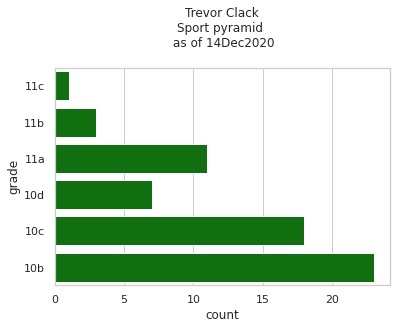

  grade  count
0   11c      1
1   11b      3
2   11a     11
3   10d      7
4   10c     18
5   10b     23


		top 10
          date               route grade style lead_style   type
126 2020-04-18        Lean Cuisine  11.6  Lead   Redpoint  Sport
344 2019-04-15       Space Cowboys  11.3  Lead    Onsight  Sport
345 2019-04-15            Sun Dogs  11.3  Lead    Onsight  Sport
179 2020-01-01          [Redacted]  11.3  Lead   Redpoint  Sport
16  2020-11-29   Smoke and Mirrors    11  Lead   Redpoint  Sport
171 2020-01-12        Agent Orange    11  Lead   Redpoint  Sport
117 2020-05-03      Moby's Revenge    11  Lead    Onsight  Sport
208 2019-08-30      Pistol Whipped    11  Lead   Redpoint  Sport
17  2020-11-29               Foops    11  Lead   Redpoint  Sport
137 2020-03-21  Internet Superstar    11  Lead   Redpoint  Sport


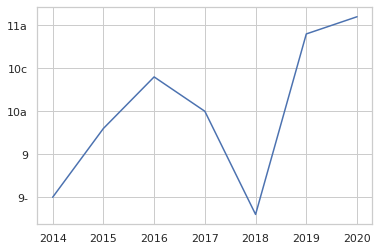

In [ ]:
document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"  # Morgan
# document = "https://www.mountainproject.com/user/106234022/stormeh/tick-export" # Ryan Murphy
# document = "https://www.mountainproject.com/user/107183979/f-y/tick-export" # F Y - anaonymous strong climber I found
# document = "https://www.mountainproject.com/user/200029217/michael-tassone/tick-export"
# area_url = "https://www.mountainproject.com/area/classics/108189726/fairview-mountain"
area_url = "https://www.mountainproject.com/area/classics/105931166/central-pinnacles"
P = Pyramid(document)
# P.make_recommendations(area_url)
# P.show_pyramids('trad')
P.show_pyramids()
# P.yearly_mileage
P.yearly_progress()
# TODO: fix the show_pyramids, with 'None' it shows one then doesn't show the other

# Ignore Below
Below is the "sratch work" that has been already incorporated above or is a work in progress 

### Class with Plotly

In [3]:
import pandas as pd
import numpy as np
from math import floor, ceil
from datetime import datetime as dt
import plotly.express as px
import plotly.graph_objects as go

class Pyramid:
  def __init__(self,document):
    self.document = document
    self.climber = document.split('/')[-2].replace('-',' ').title()
    self.grade_chart = pd.read_html("https://www.mountainproject.com/international-climbing-grades")
    self.old_ropes = self.grade_chart[0].YDSUSA[:-1].to_list()
    self.new_ropes = [0,0,0,0,1,2,3,4,5,6,7,7.4,8,8.4,8.8,9,9.4,9.8]+list(np.round(np.arange(10,16,.1),1))
    self.ropes_convert = dict(zip(self.old_ropes, self.new_ropes))
   
    self.data = self._clean_data(self.document)
    # Split Trad and Sport data
    self.trad = self.data[(self.data['type'] == 'Trad') | (self.data['type'] == 'Trad, Sport') | (self.data['type'] == 'Trad, Alpine') | (self.data['type'] == 'Trad, Aid')]
    self.sport = self.data[(self.data['type'] == 'Sport') | (self.data['type'] == 'Sport, TR')]
    self.trad_rp = self.trad[self.trad.lead_style.isin(['Redpoint','Pinkpoint'])]
    self.trad_os = self.trad[self.trad.lead_style == 'Onsight']
    self.trad_os.grade.apply(self._x_round).value_counts().sort_index(ascending=False)
    self.sport_rp = self.sport[self.sport.lead_style.isin(['Redpoint','Pinkpoint'])]
    self.sport_os = self.sport[self.sport.lead_style == 'Onsight']

    self.sport_combined = pd.concat([self.sport_rp,self.sport_os], axis=0)
    self.trad_combined = pd.concat([self.trad_rp, self.trad_os], axis=0)
    self.styles = [self.sport_combined, self.trad_combined]
    date = dt.now().strftime('%-d%b%Y')
    self.pyramids = []
    self.titles = []
    for i, style in enumerate(self.styles):
      if not style.empty:
        self.title = f"{self.climber}\n{style.iloc[0]['type'].split(',')[0]} pyramid \n as of {date}\n"
        self.top_pyramid = style.grade.apply(self._x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
        self.top_pyramid.columns = ('grade','count')
        self.top_pyramid.grade = self.top_pyramid.grade.apply(self._grade_to_letter)
        self.pyramids.append(self.top_pyramid)
        self.titles.append(self.title)
    
    self.sport_pyramid = self.pyramids[0]
    self.trad_pyramid = self.pyramids[1]

    self.grades_list = '0 1 2 3 4 5 6 7 7+ 8- 8 8+ 9- 9 9+'.split()
    self.numbs = '10 11 12 13 14 15'.split()
    self.letters =  list('abcd')
    for i in self.numbs:
      for j in self.letters:
        self.grades_list.append(i+j)

  def _sum_miles(self, length_data):
    min_date = length_data.Date.min().year
    max_date = length_data.Date.max().year + 1
    front_dates = list(range(min_date,max_date))
    back_dates = [d + 1 for d in front_dates]
    front_dates = [f'01/01/{y}' for y in front_dates]
    back_dates = [f'01/01/{y}' for y in back_dates]
    date_list = list(zip(front_dates,back_dates))
    self.date_list = date_list # save for use in "yearly_progress"
    yearly_mileage = {}
    for start, end in date_list:
      year = start[-4:]
      length = round(length_data[(length_data.Date >= start) & (length_data.Date <= end)].Length.sum()/5280,3)
      yearly_mileage[year] = length
    return yearly_mileage

  # @staticmethod
  def _clean_data(self,document):
    data = pd.read_csv(document)
    data.Date = pd.to_datetime(data.Date)
    length_data = data[['Date', 'Length']]
    self.yearly_mileage = self._sum_miles(length_data)
    data = data[['Date','Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
    
    data = data.rename(columns = (dict(zip(data.columns,['date', 'route', 'grade', 'style', 'lead_style', 'type']))))
    data.grade = data.grade.apply(self._clean_grade)
    data = data[data['style'] == 'Lead']
    data = data[data.grade.apply(lambda x: type(x) in [int,np.int64, float, np.float64])] # get rid of strings (ex WI)
    return data

  # @staticmethod
  def _clean_grade(self, grade):
    grade = str(grade).split()[0]
    if grade[0] == '5':
      grade = self.ropes_convert[grade]
    return grade

  # @staticmethod
  def _x_round(self, x):
    """ rounds back to decimanls that can be reversed to letter grades
    for 10 and greater, rounds down to nearest .25
    eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
    and sub 10 numbers n to n.0, n.4 or n.8 whichever is closest - rounds down in ties
    """
    if x >= 10:
      return floor(x*4)/4
    else:
      base = floor(x)
      return_map = {x - base : 0, abs(x - base -.4): .4, abs(x - base - .8): .8}
      end = return_map[min(x-base, abs(x-base-.4), abs(x-base-.8))]
      return float(base + end)

  # @staticmethod
  def _grade_to_letter(self, grade):
    letter_map = {'.0':'a', '.25':'b', '.5':'c', '.75':'d'}
    letter_map_low = {'.0':'-', '.4':'', '.8':'+'}
    grade = float(grade) # ensure eg. 7 is 7.0 for proper mapping
    if grade >= 10:
      grade = str(grade)
      grade = grade[:2] + letter_map[grade[2:]]
      return grade
    else:
      grade = str(grade)
      grade = grade[:1] + letter_map_low[grade[1:]]
      return grade
    
  # Rounding Key example:

  # 10a, 10-, 10a/b  -> 10a
  # 10b, 10          -> 10b
  # 10b/c, 10c, 10+  -> 10c
  # 10c/d, 10d       -> 10d

  def _grade_to_number(self, grade):
    letter_map = {'a':'.0', 'b':'.25', 'c':'.5', 'd':'.75', '-':'.0', '+':'.8'}
    if grade[-1].isnumeric() == False:
      grade = grade[:-1] + letter_map[grade[-1]]
      print(grade)
    else:
      grade += '.4'
      print(grade)


  def yearly_progress(self):
    years = []
    avgs = []
    labels = []
    for start, end in self.date_list:
      year = start[-4:]
      year_df = self.data[(self.data.date < end) & (self.data.date >= start)].sort_values('grade',ascending=False) # get year and arrange values
      year_df = year_df[~year_df['lead_style'].isin(['Fell/Hung', np.nan]) & ~year_df['style'].isin(['TR','Follow', np.nan])] # keep nans because at some piont Mountain Project included the tick type. Give benefit of doubt and assume they were all successful climbs
      year_df = year_df[:10]
    
      try:
        year_avg =  round(year_df.grade.mean(),1) 
        year_avg_grade = self._grade_to_letter(self._x_round(year_avg))
      except:
        year_avg = 0
        year_avg_grade = '5.0'
  
      years.append(year)
      avgs.append(year_avg)
      labels.append(year_avg_grade)
      
    avgs = [x if x != 0 else None for x in avgs] 
    #fig, ax = plt.subplots()
    
    #plt.plot(years, avgs)
    # change labels from numbers to letter grades
    #fig.canvas.draw()
    #old_labels = [item.get_text() for item in ax.get_yticklabels()]
    #new_labels = [self._grade_to_letter(self._x_round(float(label))) for label in old_labels]
    #ax.set_yticklabels(new_labels)
    #plt.show(); #TODO
    ##########################################################################################################
    """
    

    bottom, top = floor(min(avgs)), ceil(max(avgs))
    label_range = sorted(list(set([float(x_round(grade)) for grade in new_ropes if (bottom <= grade <= top)])))
    # print(label_range)
    label_range_labels = [grade_to_letter(g) for g in label_range]
    """
    bottom, top = floor(min(avgs)), ceil(max(avgs))
    label_range = sorted(list(set([float(self._x_round(grade)) for grade in self.new_ropes if (bottom <= grade <= top)])))
    # print(label_range)
    label_range_labels = [self._grade_to_letter(g) for g in label_range]
    fig2 = go.Figure(data=go.Scatter(x=years, y=avgs))
    fig2.update_layout(yaxis = dict(
                     tickvals=label_range,
                      ticktext=label_range_labels))
    fig2.show()


    # TODO: make "none" a default argument, if none, return all (boulder maybe in future)
    # otherwise return sport, trad, etc. if 'sport' or 'trad' is included
  def show_pyramids(self,pyramid_style='sport'):
    if pyramid_style == 'sport':
      self.style = self.styles[0]
      self.top_pyramid = self.pyramids[0]
      self.title = self.titles[0]
    elif pyramid_style == 'trad':
      self.style = self.styles[1]
      self.top_pyramid = self.pyramids[1]
      self.title = self.titles[1]
    #sb.barplot(y='grade', x='count', data=self.top_pyramid, color='green')
    fig = px.bar(self.top_pyramid, x="count", y="grade", orientation='h')
    fig.layout.yaxis=dict(autorange="reversed")
    fig.show()
    #plt.title(self.title)
    #plt.show()
    print(self.top_pyramid)
    print('\n\n\t\ttop 10')
    print(self.style.sort_values('grade',ascending=False).head(10))
    return None # I think I want none because I just want to display pyramids for now. Else return self.pyramids


  # TODO: run show_pyramid first to establish trad or sport pyramid or.... pull stuff out of show_pyramid first into __init__ 
  # making show_pyramids into something smaller. REASON: show_pyramids has to be called before suggest_pyramid because it establishes
  # what self.sport_pyramid and self.trad_pyramid are
  def suggest_pyramid(self, pyramid_style='sport'):
    if pyramid_style == 'sport':
      self.pyramid = self.sport_pyramid
    elif pyramid_style == 'trad':
      self.pyramid = self.trad_pyramid
    # else:
    #   print('perform method "show_pyramid" first')
    #   return None
    self.scheme = [1,2,4,8,12] # may need to pass in later or set as "class global"
    
    self.top_index = self.grades_list.index(self.pyramid.grade[0]) + 1
    self.user_grade_count_dict = dict(zip(self.pyramid.grade, self.pyramid['count']))
    self.top_5_grades = self.grades_list[self.top_index : self.top_index - 5 : -1]
    self.top_5_count = [ self.user_grade_count_dict.get(grade,0) for grade in self.top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent

    self.pyramid_copy = pd.DataFrame(zip(self.top_5_grades, self.top_5_count), columns = ['grade','count']).iloc[:5]
    self.pyramid_copy['ideal_count'] = self.scheme
    self.pyramid_copy['todo'] = self.pyramid_copy.ideal_count - self.pyramid_copy['count']
    self.pyramid_copy.todo = self.pyramid_copy.todo.apply(lambda x: 0 if (x < 1) else x) # negative numbers -> 0 
    return self.pyramid_copy

  def make_recommendations(self, area_url, pyramid_style='sport'):
    self.table = pd.read_html(area_url)[1]
    self.table = self.table[self.table.Difficulty.str.startswith('5.')]
    # grades
    self.grades = self.table.Difficulty.apply(lambda x: x.split()[0])
    self.grades = self.grades.apply(lambda x: self._x_round(self.ropes_convert[x])).apply(self._grade_to_letter) # remove V grades, convert to simplified letter grades
    # routes
    self.routes = self.table['Route Name'].apply(lambda x: ' '.join(x.split()[1:]))
    # putting them together
    self.recommendations_dict = {'grade':self.grades, 'route':self.routes}
    self.recommendations_df = pd.DataFrame(self.recommendations_dict)
    ########### redundant in "suggest_pyramids" method, consider making DRY (global?) #########
    self.top_index = self.grades_list.index(self.sport_pyramid.grade[0]) + 1
    self.user_grade_count_dict = dict(zip(self.sport_pyramid.grade, self.sport_pyramid['count']))
    self.top_5_grades = self.grades_list[self.top_index : self.top_index - 5 : -1] # list of top grades as string
    self.top_5_count = [ self.user_grade_count_dict.get(grade,0) for grade in self.top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent
    ###################################################################################
    #another add in ##
    self.successful_climbs = self.data[(self.data.lead_style == 'Redpoint') | (self.data.lead_style =='Onsight')]
    self.successful_climbs.grade = self.successful_climbs.grade.apply(lambda x: self._grade_to_letter(self._x_round(x)))
    self.successful_climbs_stack = self.successful_climbs[['grade','route']]
    # successful_climbs_stack
    #end add in
    self.suggested_pyramid = self.suggest_pyramid(pyramid_style)
    self.recommendations_df = self.recommendations_df[self.recommendations_df.route.isin(self.successful_climbs_stack.route) == False] # returns area classics that haven't been climbed
    self.recommendations_df = self.recommendations_df[self.recommendations_df.grade.str.contains('|'.join(self.top_5_grades))][::-1].reset_index(drop=True) # returns the right grade range (| in the string will give an "or" effect)
    self.recommendations_df[self.recommendations_df.grade.isin(self.suggested_pyramid[self.suggested_pyramid.todo > 0].grade)] # remove grades within the suggested range that have been "overclimbed"
    # print(recommendations_df)
    return self.recommendations_df

In [4]:
document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"  # Morgan
# document = "https://www.mountainproject.com/user/106234022/stormeh/tick-export" # Ryan Murphy
# document = "https://www.mountainproject.com/user/107183979/f-y/tick-export" # F Y - anaonymous strong climber I found
# document = "https://www.mountainproject.com/user/200029217/michael-tassone/tick-export"
# area_url = "https://www.mountainproject.com/area/classics/108189726/fairview-mountain"
area_url = "https://www.mountainproject.com/area/classics/105931166/central-pinnacles"
P = Pyramid(document)
# P.make_recommendations(area_url)
# P.show_pyramids('trad')
P.show_pyramids()
# P.yearly_mileage
P.yearly_progress()
# TODO: fix the show_pyramids, with 'None' it shows one then doesn't show the other

  grade  count
0   11d      1
1   11c      1
2   11b      4
3   11a     11
4   10d      7
5   10c     18


		top 10
          date                   route grade style lead_style   type
22  2021-01-01           Rainbow Drive  11.9  Lead   Redpoint  Sport
178 2020-04-18            Lean Cuisine  11.6  Lead   Redpoint  Sport
397 2019-04-15                Sun Dogs  11.3  Lead    Onsight  Sport
396 2019-04-15           Space Cowboys  11.3  Lead    Onsight  Sport
20  2021-01-01  To Infinity and Beyond  11.3  Lead    Onsight  Sport
231 2020-01-01              [Redacted]  11.3  Lead   Redpoint  Sport
165 2020-05-23           Brown Recluse    11  Lead   Redpoint  Sport
227 2020-01-12             Dark Matter    11  Lead    Onsight  Sport
69  2020-11-29                   Foops    11  Lead   Redpoint  Sport
169 2020-05-03          Moby's Revenge    11  Lead    Onsight  Sport


### Hierarchy to further subdivide pyramid (graph object)

In [5]:
document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor

P = Pyramid(document)
location_list = pd.read_csv(document).Location.unique()
location_list

array(['California > Joshua Tree National Park > *Joshua Tree Bouldering* > Hidden Valley Area Bouldering > Hidden Valley Campground Bouldering > Manx/Asteroid Belt Circuit > Manx Boulders Circuit > The Pig Sty',
       'California > Joshua Tree National Park > Indian Cove > Indian Cove Campground > Billboard Buttress',
       'California > Joshua Tree National Park > Pinto Basin > Split Rocks > Isles in the Sky > Isles in the Sky (Southeast Face)',
       'California > Joshua Tree National Park > Pinto Basin > Split Rocks > Screamer Rocks > Brit Corridor',
       'California > Joshua Tree National Park > Pinto Basin > Split Rocks > Screamer Rocks > Cling or Fling Corridor',
       'California > Joshua Tree National Park > Pinto Basin > Live Oak Picnic Area > The Whispering Wall',
       'California > Joshua Tree National Park > Pinto Basin > Split Rocks > Approach Road Crag > East Side',
       "California > Joshua Tree National Park > Pinto Basin > Live Oak Picnic Area > Big Bob's Bi

In [6]:
top = []
edge_list = []
node_list = []
for l in location_list:
  sub_list = l.split(' > ')
  first_item = sub_list[0]
  if not first_item in top:
    top.append(first_item)
  for i in range(0, len(sub_list)):
    if not sub_list[i] in node_list:
      node_list.append(sub_list[i])
    if i == len(sub_list)-1:
      break
    
    pair = '>'.join([sub_list[i],sub_list[i+1]])
    if not pair in edge_list:
      edge_list.append(pair)
  # print(edge_list)

print(len(edge_list))
print(edge_list)
print(len(node_list))
print(node_list)
# print(edge_list)
print(len(top))
print(top)

484
['California>Joshua Tree National Park', 'Joshua Tree National Park>*Joshua Tree Bouldering*', '*Joshua Tree Bouldering*>Hidden Valley Area Bouldering', 'Hidden Valley Area Bouldering>Hidden Valley Campground Bouldering', 'Hidden Valley Campground Bouldering>Manx/Asteroid Belt Circuit', 'Manx/Asteroid Belt Circuit>Manx Boulders Circuit', 'Manx Boulders Circuit>The Pig Sty', 'Joshua Tree National Park>Indian Cove', 'Indian Cove>Indian Cove Campground', 'Indian Cove Campground>Billboard Buttress', 'Joshua Tree National Park>Pinto Basin', 'Pinto Basin>Split Rocks', 'Split Rocks>Isles in the Sky', 'Isles in the Sky>Isles in the Sky (Southeast Face)', 'Split Rocks>Screamer Rocks', 'Screamer Rocks>Brit Corridor', 'Screamer Rocks>Cling or Fling Corridor', 'Pinto Basin>Live Oak Picnic Area', 'Live Oak Picnic Area>The Whispering Wall', 'Split Rocks>Approach Road Crag', 'Approach Road Crag>East Side', "Live Oak Picnic Area>Big Bob's Big Wedge", '*Joshua Tree Bouldering*>Queen Valley Area Bou

In [7]:
import networkx as nx
G = nx.DiGraph()
for node in node_list:
  G.add_node(node)
for edge in edge_list:
  source, child = edge.split('>')
  G.add_edge(source,child)
# OLD SOLUTION: Not directed
# G = nx.parse_edgelist(edge_list, data=False, delimiter='>')
# TODO : add directionality (so california for example only descends to Jtree, Yosemite, etc. 

In [20]:
G.nodes.data()

NodeDataView({'California': {}, 'Joshua Tree National Park': {}, '*Joshua Tree Bouldering*': {}, 'Hidden Valley Area Bouldering': {}, 'Hidden Valley Campground Bouldering': {}, 'Manx/Asteroid Belt Circuit': {}, 'Manx Boulders Circuit': {}, 'The Pig Sty': {}, 'Indian Cove': {}, 'Indian Cove Campground': {}, 'Billboard Buttress': {}, 'Pinto Basin': {}, 'Split Rocks': {}, 'Isles in the Sky': {}, 'Isles in the Sky (Southeast Face)': {}, 'Screamer Rocks': {}, 'Brit Corridor': {}, 'Cling or Fling Corridor': {}, 'Live Oak Picnic Area': {}, 'The Whispering Wall': {}, 'Approach Road Crag': {}, 'East Side': {}, "Big Bob's Big Wedge": {}, 'Queen Valley Area Bouldering': {}, 'Queen Mountain Bouldering': {}, 'Queen Mountain Base': {}, 'Bighorn Pass Boulders': {}, 'Crystal Skull': {}, 'Hidden Valley Area': {}, 'Hidden Valley Campground': {}, 'Cyclops Rock': {}, 'High Desert': {}, 'Barstow Area': {}, 'New Jack City': {}, 'Box Canyon West': {}, 'Toy Block': {}, 'Cliffs of Insanity': {}, 'Predator Wall

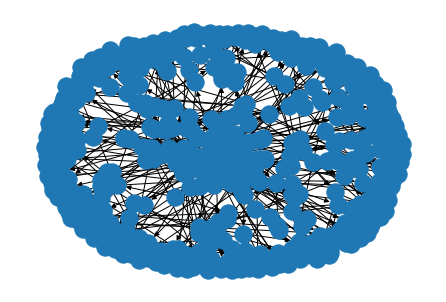

In [31]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels = False )

## Redpoint/Onsight ladders

In [ ]:
# Person being considered

# document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"
document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"

In [ ]:
import pandas as pd
import numpy as np
from math import floor
from datetime import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(style='whitegrid')

In [ ]:
# Get Grade for conversion (from Mountain Project's official grade converter)
grade_chart = pd.read_html("https://www.mountainproject.com/international-climbing-grades")
old_ropes = grade_chart[0].YDSUSA[:-1].to_list()
new_ropes = [0,0,0,0,1,2,3,4,5,6,7,7.4,8,8.4,8.8,9,9.4,9.8]+list(np.round(np.arange(10,16,.1),1))
ropes_convert = dict(zip(old_ropes,new_ropes))

In [ ]:
# Supporting functions for clean and prep pipeline
def clean_grade(grade):
  grade = str(grade).split()[0]
  if grade[0] == '5':
    grade = ropes_convert[grade]
    return grade

def x_round(x):
  """ rounds down to nearest .25
  eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
  """
  if x >= 10:
    return floor(x*4)/4
  else: return x


# Rounding Key example:

# 10a, 10-, 10a/b  -> 10a
# 10b, 10          -> 10b
# 10b/c, 10c, 10+  -> 10c
# 10c/d, 10d       -> 10d

# def grade_to_number(grade):
#   letter_map = {'a':'.0', 'b':'.25', 'c':'.5', 'd':'.75', '-':'.0', '+':'.8'}
#   if grade[-1].isnumeric() == False:
#     grade = grade[:-1] + letter_map[grade[-1]]
#     print(grade)
#   else:
#     grade += '.4'
#     print(grade)


def grade_to_letter(grade):
  letter_map = {'.0':'a', '.25':'b', '.5':'c', '.75':'d'}
  letter_map_low = {'.0':'-', '.4':'', '.8':'+'}
  if grade >= 10:
    grade = str(grade)
    grade = grade[:2] + letter_map[grade[2:]]
    return grade
  else:
    grade = str(grade)
    grade = grade[:1] + letter_map_low[grade[1:]]
    return grade


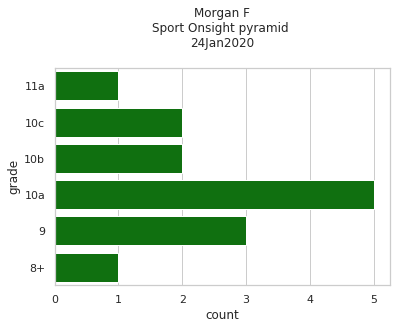

  grade  count
0   11a      1
1   10c      2
2   10b      2
3   10a      5
4     9      3
5    8+      1


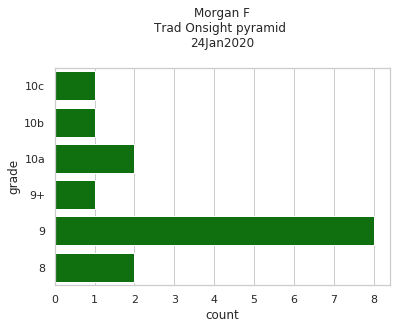

  grade  count
0   10c      1
1   10b      1
2   10a      2
3    9+      1
4     9      8
5     8      2


In [ ]:
climber = document.split('/')[-2].replace('-',' ').title()
date = dt.now().strftime('%-d%b%Y')
data = pd.read_csv(document)
data = data[['Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
data = data.rename(columns = (dict(zip(data.columns,['route', 'grade', 'style', 'lead_style', 'type']))))
data.grade = data.grade.apply(clean_grade)
data = data[data['style'] == 'Lead']
# Split Trad and Sport data
trad = data[(data['type'] == 'Trad') | (data['type'] == 'Trad, Sport') | (data['type'] == 'Trad, Alpine') | (data['type'] == 'Trad, Aid')]
sport = data[(data['type'] == 'Sport') | (data['type'] == 'Sport, TR')]
trad_rp = trad[trad.lead_style == 'Redpoint']
trad_os = trad[trad.lead_style == 'Onsight']
trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)
sport_rp = sport[sport.lead_style == 'Redpoint']
sport_os = sport[sport.lead_style == 'Onsight']


styles = [sport_os, sport_rp, trad_os, trad_rp]

for style in styles:
  if not style.empty:
    title = f"{climber}\n{style.iloc[0]['type'].split(',')[0]} {style.iloc[0].lead_style} pyramid \n{date}\n"
    top_pyramid = style.grade.apply(x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
    top_pyramid.columns = ('grade','count')
    top_pyramid.grade = top_pyramid.grade.apply(grade_to_letter)
    sb.barplot(y='grade', x='count', data=top_pyramid, color='green')
    plt.title(title)
    plt.show()
    print(top_pyramid)



In [ ]:
successful_climbs = data[(data.lead_style == 'Redpoint') | (data.lead_style =='Onsight')]
successful_climbs.grade = successful_climbs.grade.apply(lambda x: grade_to_letter(x_round(x)))
successful_climbs_stack = successful_climbs[['grade','route']]
successful_climbs_stack

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,grade,route
1,10a,Little Red Book
2,10a,Easy Prey
3,11a,Hole In One
4,10a,Dream of Wild Turkeys
5,10b,Stolen Chimney
18,9,Crooked Dick Spire
19,10a,Holey Moley
24,10b,Ants Go Marching
27,9,Crag Rat
28,9,The Squamish Butt Face


## Combined redpoint and os pyramid

In [ ]:
def make_pyramid(document):
  climber = document.split('/')[-2].replace('-',' ').title()
  date = dt.now().strftime('%-d%b%Y')
  data = pd.read_csv(document)
  data = data[['Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
  data = data.rename(columns = (dict(zip(data.columns,['route', 'grade', 'style', 'lead_style', 'type']))))
  data.grade = data.grade.apply(clean_grade)
  data = data[data['style'] == 'Lead']
  # Split Trad and Sport data
  trad = data[(data['type'] == 'Trad') | (data['type'] == 'Trad, Sport') | (data['type'] == 'Trad, Alpine') | (data['type'] == 'Trad, Aid')]
  sport = data[(data['type'] == 'Sport') | (data['type'] == 'Sport, TR')]
  trad_rp = trad[trad.lead_style == 'Redpoint']
  trad_os = trad[trad.lead_style == 'Onsight']
  trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)
  sport_rp = sport[sport.lead_style == 'Redpoint']
  sport_os = sport[sport.lead_style == 'Onsight']

  sport_combined = pd.concat([sport_rp,sport_os], axis=0)
  trad_combined = pd.concat([trad_rp, trad_os], axis=0)
  styles = [sport_combined, trad_combined]

  pyramids = []
  for style in styles:
    if not style.empty:
      title = f"{climber}\n{style.iloc[0]['type'].split(',')[0]} pyramid \n as of {date}\n"
      top_pyramid = style.grade.apply(x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
      top_pyramid.columns = ('grade','count')
      top_pyramid.grade = top_pyramid.grade.apply(grade_to_letter)
      sb.barplot(y='grade', x='count', data=top_pyramid, color='green')
      plt.title(title)
      plt.show()
      print(top_pyramid)
      print('\n\n\t\ttop 10')
      print(style.sort_values('grade',ascending=False).head(10))
      pyramids.append(top_pyramid)

  return pyramids

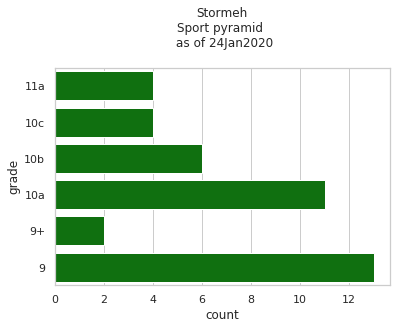

  grade  count
0   11a      4
1   10c      4
2   10b      6
3   10a     11
4    9+      2
5     9     13


		top 10
               route  grade style lead_style   type
6       Agent Orange   11.2  Lead   Redpoint  Sport
122              Pop   11.0  Lead   Redpoint  Sport
125   Dihedral Dance   11.0  Lead    Onsight  Sport
96     Totally Clips   11.0  Lead    Onsight  Sport
131      Blue Collar   10.6  Lead    Onsight  Sport
126  Blockade Runner   10.6  Lead    Onsight  Sport
89           Slacker   10.6  Lead    Onsight  Sport
8         False Flag   10.5  Lead    Onsight  Sport
88            Hubble   10.3  Lead    Onsight  Sport
18            Moucha   10.3  Lead    Onsight  Sport


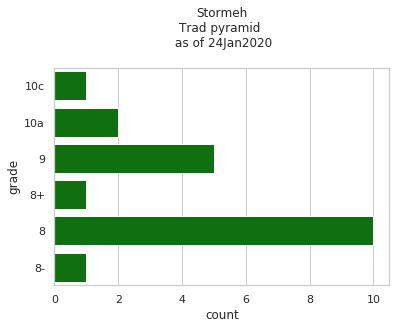

  grade  count
0   10c      1
1   10a      2
2     9      5
3    8+      1
4     8     10
5    8-      1


		top 10
                     route  grade style lead_style  type
41   The Squamish Buttress   10.6  Lead    Onsight  Trad
97              Panty Raid   10.0  Lead    Onsight  Trad
45             Pearly Gate   10.0  Lead    Onsight  Trad
145              The Horse    9.4  Lead    Onsight  Trad
4     Tales from the Crypt    9.4  Lead    Onsight  Trad
107         Ashtar Command    9.4  Lead    Onsight  Trad
39        St. Vitus' Dance    9.4  Lead    Onsight  Trad
43            Cold Comfort    9.4  Lead    Onsight  Trad
87            Vorpal Sword    8.8  Lead    Onsight  Trad
72                Planet X    8.4  Lead    Onsight  Trad


In [ ]:
# document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"  # Morgan
document = "https://www.mountainproject.com/user/106234022/stormeh/tick-export" # Ryan Murphy

sport_pyramid, trad_pyramid = make_pyramid(document)

## Make suggestions to "fill out" pyramid

In [ ]:
# pros are usually 1, 3, 20, 50, 100 (based on 8a.nu)
# intermediate maybe 1, 3, 10, 20, 30
# 1 2 4 8 12 seems reasonable for a beginner


sport_pyramid

,grade,count
0,11a,4
1,10c,4
2,10b,6
3,10a,11
4,9+,2
5,9,13


In [ ]:
grades_list = '0 1 2 3 4 5 6 7 7+ 8- 8 8+ 9- 9 9+'.split()

numbs = '10 11 12 13 14 15'.split()
letters =  list('abcd')
for i in numbs:
  for j in letters:
    grades_list.append(i+j)

def suggest_pyramid(pyramid):
  scheme = [1,2,4,8,12] # may need to pass in later or set as "class global"
  print(pyramid.copy().iloc[0].grade)
  top_index = grades_list.index(pyramid.grade[0]) + 1

  user_grade_count_dict = dict(zip(pyramid.grade, pyramid['count']))
  top_5_grades = grades_list[top_index : top_index - 5 : -1]
  top_5_count = [ user_grade_count_dict.get(grade,0) for grade in top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent

  pyramid_copy = pd.DataFrame(zip(top_5_grades, top_5_count), columns = ['grade','count']).iloc[:5]
  pyramid_copy['ideal_count'] = scheme
  pyramid_copy['todo'] = pyramid_copy.ideal_count - pyramid_copy['count']
  pyramid_copy.todo = pyramid_copy.todo.apply(lambda x: 0 if (x < 1) else x) # negative numbers -> 0 
  print(pyramid_copy)
  return pyramid_copy

In [ ]:
suggested_pyramid = suggest_pyramid(sport_pyramid)

11a
  grade  count  ideal_count  todo
0   11b      0            1     1
1   11a      4            2     0
2   10d      0            4     4
3   10c      4            8     4
4   10b      6           12     6


In [ ]:
## Scraping to make recommendations
url  = "https://www.mountainproject.com/area/classics/105865045/new-jack-city"
url = "https://www.mountainproject.com/area/classics/108189726/fairview-mountain"
import pandas as pd
import numpy as np
table = pd.read_html(url)[1]
table = table[table.Difficulty.str.startswith('5.')]
# grades
grades = table.Difficulty.apply(lambda x: x.split()[0])
grades = grades.apply(lambda x: x_round(ropes_convert[x])).apply(grade_to_letter) # remove V grades, convert to simplified letter grades
# routes
routes = table['Route Name'].apply(lambda x: ' '.join(x.split()[1:]))
# putting them together
recommendations_dict = {'grade':grades, 'route':routes}
recommendations_df = pd.DataFrame(recommendations_dict)

###################################################
#TEMP - make global/classvariable: assume we have user's 5 sought after grades: 
top_index = grades_list.index(sport_pyramid.grade[0]) + 1
user_grade_count_dict = dict(zip(sport_pyramid.grade, sport_pyramid['count']))
top_5_grades = grades_list[top_index : top_index - 5 : -1] # list of top grades as string
top_5_count = [ user_grade_count_dict.get(grade,0) for grade in top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent
###################################################

recommendations_df = recommendations_df[recommendations_df.route.isin(successful_climbs_stack.route) == False] # returns area classics that haven't been climbed
recommendations_df = recommendations_df[recommendations_df.grade.str.contains('|'.join(top_5_grades))][::-1].reset_index(drop=True) # returns the right grade range (| in the string will give an "or" effect)
recommendations_df[recommendations_df.grade.isin(suggested_pyramid[suggested_pyramid.todo > 0].grade)] # remove grades within the suggested range that have been "overclimbed"

,grade,route
0,11b,Clone Army
6,10d,Light Saber
7,10d,Stretch Armstrong
8,10d,Jangofet
9,10d,Mojave Green
10,10c,Yoda
11,10c,Space Wrangler
12,10c,Sidewinder
13,10c,Black Dog
14,10c,False Flag


### calculate climbing "mileage"

In [ ]:
import pandas as pd
tmp_df = pd.read_csv(document)

NameError: ignored

In [ ]:
tmp_df.head()
dist = tmp_df['Length'].sum()
tmp_df.Date = pd.to_datetime(tmp_df.Date)
date_list = [('01/01/2015','01/01/2016'),('01/01/2016','01/01/2017'),('01/01/2017','01/01/2018'),('01/01/2018','01/01/2019'),('01/01/2019','01/01/2020'),('01/01/2020','01/01/2021')]
for start, end in date_list:
  year = start[-4:]
  length = tmp_df[(tmp_df.Date <= end) & (tmp_df.Date >= start)].Length.sum()/5280
  print(f'{year}: {length}')

2015: 0.7575757575757576
2016: 1.168939393939394
2017: 1.4532196969696969
2018: 0.6990530303030303
2019: 3.133901515151515
2020: 0.8087121212121212


In [ ]:

document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"  # Morgan

tmp_df = pd.read_csv(document)
tmp_df.Date = pd.to_datetime(tmp_df.Date)
min_date = tmp_df.Date.min().year
max_date = tmp_df.Date.max().year + 1
front_dates = list(range(min_date,max_date))
back_dates = [d + 1 for d in front_dates]
front_dates = [f'01/01/{y}' for y in front_dates]
back_dates = [f'01/01/{y}' for y in back_dates]
date_list = list(zip(front_dates,back_dates))
for start, end in date_list:
  year = start[-4:]
  length = round(tmp_df[(tmp_df.Date <= end) & (tmp_df.Date >= start)].Length.sum()/5280,3)
  print(f'{year}: {length} miles')

2014: 0.347 miles
2015: 0.758 miles
2016: 1.169 miles
2017: 1.453 miles
2018: 0.699 miles
2019: 3.134 miles
2020: 0.97 miles


### rolling progress (plot top x ascents of the year)

In [ ]:
def test_round(x):
  """ rounds down to nearest .25
  eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
  and sub 10 numbers n to n.0, n.4 or n.8 whichever is closest - rounds down in ties
  """
  if x >= 10:
    return floor(x*4)/4
  else:
    base = floor(x)
    return_map = {x - base : 0, abs(x - base -.4): .4, abs(x - base - .8): .8}
    end = return_map[min(x-base, abs(x-base-.4), abs(x-base-.8))]
    return float(base + end)

nums = 13* np.random.random(8)
nums[-1] = 9.2


for n in nums:
  print(n, test_round(n))


4.741813727653707 4.8
9.740963192813918 9.8
11.294078187437364 11.25
7.016405952568252 7.0
1.4677383170798897 1.4
11.123350894683249 11.0
9.492709463832515 9.4
9.2 9.0


In [ ]:
### copy of supportive functions:
import pandas as pd
import numpy as np
from math import floor, ceil
import seaborn as sb
import matplotlib.pyplot as plt

# Supporting functions for clean and prep pipeline
# Get Grade for conversion (from Mountain Project's official grade converter)
grade_chart = pd.read_html("https://www.mountainproject.com/international-climbing-grades")
old_ropes = grade_chart[0].YDSUSA[:-1].to_list()
new_ropes = [0,0,0,0,1,2,3,4,5,6,7.4,7.8,8,8.4,8.8,9,9.4,9.8]+list(np.round(np.arange(10,16,.1),1)) # missing 7- and some 15s like 15b/c
ropes_convert = dict(zip(old_ropes,new_ropes))

inv_to_grades = {v: k for k, v in ropes_convert.items()}

def clean_grade(grade):
  grade = str(grade).split()[0]
  if grade[0] == '5':
    grade = ropes_convert[grade]
    return grade

def x_round(x):
  """ rounds back to decimanls that can be reversed to letter grades
  for 10 and greater, rounds down to nearest .25
  eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
  and sub 10 numbers n to n.0, n.4 or n.8 whichever is closest - rounds down in ties
  """
  if x >= 10:
    return floor(x*4)/4
  else:
    base = floor(x)
    return_map = {x - base : 0, abs(x - base -.4): .4, abs(x - base - .8): .8}
    end = return_map[min(x-base, abs(x-base-.4), abs(x-base-.8))]
    return float(base + end)


# Rounding Key example:

# 10a, 10-, 10a/b  -> 10a
# 10b, 10          -> 10b
# 10b/c, 10c, 10+  -> 10c
# 10c/d, 10d       -> 10d

# def grade_to_number(grade):
#   letter_map = {'a':'.0', 'b':'.25', 'c':'.5', 'd':'.75', '-':'.0', '+':'.8'}
#   if grade[-1].isnumeric() == False:
#     grade = grade[:-1] + letter_map[grade[-1]]
#     print(grade)
#   else:
#     grade += '.4'
#     print(grade)


def grade_to_letter(grade):
  letter_map = {'.0':'a', '.25':'b', '.5':'c', '.75':'d'}
  letter_map_low = {'.0':'-', '.4':'', '.8':'+'}
  # print('in grade_to_letter mapping:', grade)
  if grade >= 10:
    grade = str(grade)
    grade = grade[:2] + letter_map[grade[2:]]
    return grade
  else:
    grade = str(grade)
    grade = grade[:1] + letter_map_low[grade[1:]]
    return grade

In [ ]:
document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"  # Morgan
document = "https://www.mountainproject.com/user/107183979/f-y/tick-export"
# document = "https://www.mountainproject.com/user/106234022/stormeh/tick-export" # Ryan Murphy

tmp_df = pd.read_csv(document)
# print(tmp_df.columns)
tmp_df = tmp_df[['Date', 'Route', 'Rating', 'Style', 'Lead Style']]#, 'Route Type']]
tmp_df.Date = pd.to_datetime(tmp_df.Date)
tmp_df.Rating = tmp_df.Rating.apply(clean_grade)
min_date = tmp_df.Date.min().year
max_date = tmp_df.Date.max().year + 1
front_dates = list(range(min_date,max_date))
back_dates = [d + 1 for d in front_dates]
front_dates = [f'01/01/{y}' for y in front_dates]
back_dates = [f'01/01/{y}' for y in back_dates]
date_list = list(zip(front_dates,back_dates))
year_list = []
# print(tmp_df.Style.unique())
years = []
avgs = []
labels = []
for start, end in date_list:
  year = start[-4:]
  year_df = tmp_df[(tmp_df.Date <= end) & (tmp_df.Date >= start)].sort_values('Rating',ascending=False) # get year and arrange values
  # print(year_df, year_df.value_counts())
  year_df = year_df[~year_df['Lead Style'].isin(['Fell/Hung',np.nan]) & ~year_df['Style'].isin(['TR','Follow',np.nan])] # keep nans because at some point Mountain Project included the tick type. Give benefit of doubt and assume they were all successful climbs
  year_df = year_df[:10]
  try:
    year_avg = round(year_df.Rating.mean(),1)
    # year_avg_grade = inv_to_grades[year_avg]   # remove inv_to_grades?
    year_avg_grade = grade_to_letter(x_round(year_avg))
  except:
    year_avg = 0
    year_avg_grade = '5.0'
  # print(year_avg_grade)
  # print(f'{year}: {year_avg} -- {year_avg_grade}')
  years.append(year)
  avgs.append(year_avg)
  labels.append(year_avg_grade)
  # print(f'{year}: {year_avg} -- ')
  # print(year_df['Style'].unique())
  # print(year_df.head(10), year_df.shape[0]) # uncomment to see the climbs

bottom, top = floor(min(avgs)), ceil(max(avgs))
label_range = sorted(list(set([float(x_round(grade)) for grade in new_ropes if (bottom <= grade <= top)])))
# print(label_range)
label_range_labels = [grade_to_letter(g) for g in label_range]
# print(label_range_labels)
# print(bottom, top)
# plt.plot(years, avgs)
# plt.show();
print(avgs)
avgs = [x if x != 0 else None for x in avgs]
print(avgs)

import plotly.graph_objects as go

x = np.arange(10)

fig = go.Figure(data=go.Scatter(x=years, y=avgs))
fig.update_layout(yaxis = dict(
                  tickvals=label_range,
                  ticktext=label_range_labels))
# fig.update_traces(marker_colorbar_tickvals=label_range, selector=dict(type='bar'))
# fig.update_traces(marker_colorbar_ticktext=label_range_labels, selector=dict(type='bar'))
# fig.update_traces(y=label_range_labels)
fig.show()

[0, 11.0, 0, 0, 0, 12.7, 13.2, 13.7, 13.7]
[None, 11.0, None, None, None, 12.7, 13.2, 13.7, 13.7]


In [ ]:
ropes_convert

{'3rd': 0,
 '4th': 0,
 '5.0': 0,
 '5.1': 1,
 '5.10': 10.4,
 '5.10+': 10.7,
 '5.10-': 10.1,
 '5.10a': 10.0,
 '5.10a/b': 10.2,
 '5.10b': 10.3,
 '5.10b/c': 10.5,
 '5.10c': 10.6,
 '5.10c/d': 10.8,
 '5.10d': 10.9,
 '5.11': 11.4,
 '5.11+': 11.7,
 '5.11-': 11.1,
 '5.11a': 11.0,
 '5.11a/b': 11.2,
 '5.11b': 11.3,
 '5.11b/c': 11.5,
 '5.11c': 11.6,
 '5.11c/d': 11.8,
 '5.11d': 11.9,
 '5.12': 12.4,
 '5.12+': 12.7,
 '5.12-': 12.1,
 '5.12a': 12.0,
 '5.12a/b': 12.2,
 '5.12b': 12.3,
 '5.12b/c': 12.5,
 '5.12c': 12.6,
 '5.12c/d': 12.8,
 '5.12d': 12.9,
 '5.13': 13.4,
 '5.13+': 13.7,
 '5.13-': 13.1,
 '5.13a': 13.0,
 '5.13a/b': 13.2,
 '5.13b': 13.3,
 '5.13b/c': 13.5,
 '5.13c': 13.6,
 '5.13c/d': 13.8,
 '5.13d': 13.9,
 '5.14': 14.4,
 '5.14+': 14.7,
 '5.14-': 14.1,
 '5.14a': 14.0,
 '5.14a/b': 14.2,
 '5.14b': 14.3,
 '5.14b/c': 14.5,
 '5.14c': 14.6,
 '5.14c/d': 14.8,
 '5.14d': 14.9,
 '5.15': 15.4,
 '5.15+': 15.6,
 '5.15-': 15.1,
 '5.15a': 15.0,
 '5.15a/b': 15.2,
 '5.15b': 15.3,
 '5.15c': 15.5,
 '5.15c/d': 15.7,


In [ ]:
# Mountain project redacted some route names (two that I climbed had the words "Nazi" and "Lynch" in it). Here's just a way to check
# temp = pd.read_csv(document)
# temp[temp.Route == '[Redacted]']

### OVERLAP

In [ ]:
trevor_doc = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor
morgan_doc = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"  # Morgan
ryan_doc = "https://www.mountainproject.com/user/106234022/stormeh/tick-export" # Ryan Murphy
P_ryan = Pyramid(ryan_doc)
P_trevor = Pyramid(trevor_doc)
P_morgan = Pyramid(morgan_doc)


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
url = "https://www.mountainproject.com/area/classics/108189726/fairview-mountain"
t_rec = P_trevor.make_recommendations(url)
r_rec = P_ryan.make_recommendations(url)
m_rec = P_morgan.make_recommendations(url)


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
# Merging the "todos" of everyone will find the area classics no one has done but "need to do" in order to fill their pyramids
t_rec.merge(m_rec).merge(r_rec)
# P_trevor.suggest_pyramid()

,grade,route
0,11a,High Desert Hospitality
1,11a,Solar Warrior Dynasty
2,11a,Hangnail
3,10d,Size Matters Not
4,10d,Stretch Armstrong
